Basado en https://www.kaggle.com/code/stevengolo/triplet-loss-for-neural-recommender-systems

Dataset: https://grouplens.org/datasets/movielens/

# Import

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
import tensorflow as tf


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


from tensorflow.keras import layers
from tensorflow.keras.layers import (Concatenate, Dense, Dot, Dropout,
                                     Embedding, Flatten, Input, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import random

from tqdm import tqdm

import scipy.stats
# Visualization
import seaborn as sns
# Similarity
from sklearn.metrics.pairwise import cosine_similarity


# Leer datos

Se ha usado el dataset de MovieLens Small con 100.836 ratings y 3.683 tags con 9.742 movies por 610 users. https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

## Zip

In [ ]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Dataframes

In [ ]:
# Leemos el fichero de ratings y obtenemos las 3 primeras columnas, usuario, pelicula, rating
pd_ratings = pd.read_csv('ml-latest-small/ratings.csv', usecols=[0,1,2])

In [ ]:
pd_ratings.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
print(f"Shape of the ratings data: {pd_ratings.shape}.") 

Shape of the ratings data: (100836, 3).


In [ ]:
# Leemos los metadatos de las peliculas
pd_movies = pd.read_csv('ml-latest-small/movies.csv')

In [ ]:
pd_movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
print(f"Shape of the metadata: {pd_movies.shape}.")

Shape of the metadata: (9742, 3).


In [ ]:
# Leemos los tags de las peliculas dados por los usuarios
pd_tags = pd.read_csv('ml-latest-small/tags.csv', usecols=[0,1,2])

In [ ]:
pd_tags.head(5)

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [ ]:
ratings = pd_ratings.merge(pd_movies.loc[:, ['title', 'movieId', 'genres']], left_on='movieId', right_on='movieId')

In [ ]:
ratings.head(5)

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
print(f"Shape of the complete data: {ratings.shape}.")

Shape of the complete data: (100836, 5).


In [ ]:
ratings_tags = ratings.merge(pd_tags.loc[:, ['userId', 'movieId', 'tag']], left_on=['userId', 'movieId'] , right_on=['userId', 'movieId'])

In [ ]:
ratings_tags.head(5)

,userId,movieId,rating,title,genres,tag
0,336,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
1,474,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
2,567,1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
3,289,3,2.5,Grumpier Old Men (1995),Comedy|Romance,moldy
4,289,3,2.5,Grumpier Old Men (1995),Comedy|Romance,old


In [ ]:
print(f"Shape of the complete data with tags: {ratings_tags.shape}.")

Shape of the complete data with tags: (3476, 6).


# Data Pre-Processing

To understand well the distribution of the data, the following statistics are computed

In [ ]:
print(f"Number of unique users: {ratings['userId'].unique().size}.")
print(f"Number of unique users in tags: {ratings_tags['userId'].unique().size}.")

Number of unique users: 610.
Number of unique users in tags: 54.


In [ ]:
print(f"Number of unique movies: {ratings['movieId'].unique().size}.")
print(f"Number of unique movies in tags: {ratings_tags['movieId'].unique().size}.")

Number of unique movies: 9724.
Number of unique movies in tags: 1464.


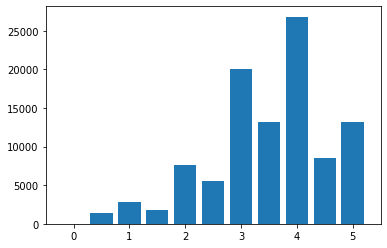

In [ ]:
# Histogram of the ratings
x, height = np.unique(ratings['rating'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(x, height, align='center', width=0.4)
ax.set(xticks=np.arange(-1, 6), xlim=[-0.5, 5.5])
plt.show()

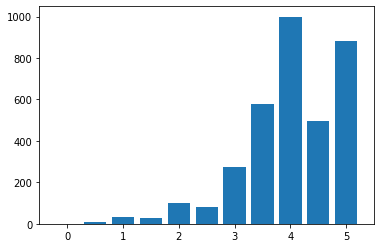

In [ ]:
# Histogram of the ratings
x, height = np.unique(ratings_tags['rating'], return_counts=True)

fig, ax = plt.subplots()
ax.bar(x, height, align='center', width=0.4)
ax.set(xticks=np.arange(-1, 6), xlim=[-0.5, 5.5])
plt.show()

In [ ]:
# Count the number of ratings for each movie
popularity = ratings.groupby('movieId').size().reset_index(name='popularity')
pd_movies = pd_movies.merge(popularity, left_on='movieId', right_on='movieId')

## Speed-up the computation

Get the most popular ones (more than  X  ratings)

In [ ]:
X = 50

In [ ]:
# Get most popular movieId
pd_movies_new = pd_movies.loc[(pd_movies['popularity'] > X)]

In [ ]:
# Create a dataframe for movieId
pd_movies_new = pd_movies_new.assign(newMovieId=pd.Series(np.arange(pd_movies_new.shape[0])).values)
pd_movies_new_indexed = pd_movies_new.set_index('newMovieId')

In [ ]:
# Merge the dataframe
ratings = ratings.merge(pd_movies_new.loc[:, ['movieId', 'newMovieId', 'popularity']], left_on='movieId', right_on='movieId')

In [ ]:
# Create a dataframe for userId
user = pd.DataFrame({'userId': np.unique(ratings['userId'])})
user = user.assign(newUserId=pd.Series(np.arange(user.shape[0])).values)

In [ ]:
# Merge the dataframe
ratings = ratings.merge(user, left_on='userId', right_on='userId')

In [ ]:
ratings.head(5)

,userId,movieId,rating,title,genres,newMovieId,popularity,newUserId
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,215,0
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance,2,52,0
2,1,6,4.0,Heat (1995),Action|Crime|Thriller,3,102,0
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,16,203,0
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,18,204,0


In [ ]:
print(f'Shape of the rating dataset: {ratings.shape}.')

Shape of the rating dataset: (40660, 8).


In [ ]:
MAX_USER_ID = ratings['newUserId'].max()
MAX_ITEM_ID = ratings['newMovieId'].max()

N_USERS = MAX_USER_ID + 1
N_ITEMS = MAX_ITEM_ID + 1

In [ ]:
print(f'Number of users: {N_USERS} / Number of movies: {N_ITEMS}')

Number of users: 606 / Number of movies: 436


## Split the dataset into train/test sets

In [ ]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)

user_id_train = np.array(train['newUserId'])
movie_id_train = np.array(train['newMovieId'])
ratings_train = np.array(train['rating'])

user_id_test = np.array(test['newUserId'])
movie_id_test = np.array(test['newMovieId'])
ratings_test = np.array(test['rating'])

In [ ]:
train_pos = train.query('rating > 3.5')
test_pos = test.query('rating > 3.5')

## Triplet Loss

In [ ]:
def identity_loss(y_true, y_pred):
    """Ignore y_true and return the mean of y_pred.
    This is a hack to work-around the design of the Keras API that is
    not really suited to train networks with a triplet loss by default.
    """
    return K.mean(y_pred) # y_pred - 0 * y_true

class MarginLoss(layers.Layer):
    """Define the loss for the triple architecture
    
    Parameters
    ----------
    margin: float, default=1.
        Define a margin (alpha)
    """
    def __init__(self, margin=1.):
        super().__init__()
        self.margin = margin
        
    def call(self, inputs):
        pos_pair_similarity = inputs[0]
        neg_pair_similarity = inputs[1]
        
        diff = neg_pair_similarity - pos_pair_similarity
        return K.maximum(diff + self.margin, 0)

In [ ]:
class TripletModel(Model):
    """Define the triplet model architecture
    
    Parameters
    ----------
    embedding_size: integer
        Size the embedding vector
    n_users: integer
        Number of user in the dataset
    n_items: integer
        Number of item in the dataset
    l2_reg: float or None
        Quantity of regularization
    margin: float
        Margin for the loss
        
    Arguments
    ---------
    margin: float
        Margin for the loss
    user_embedding: Embedding
        Embedding layer of user 
    item_embedding: Embedding
        Embedding layer of item
    flatten: Flatten
        Flatten layer
    dot: Dot
        Dot layer
    margin_loss: MarginLoss
        Loss layer
    """
    def __init__(self, n_users, n_items, embedding_size=64, l2_reg=None, margin=1.):
        super().__init__(name='TripletModel')
        
        # Define hyperparameters
        self.margin = margin
        l2_reg = None if l2_reg == 0 else l2(l2_reg)
        
        # Define Embedding layers
        self.user_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=n_users,
                                        input_length=1,
                                        input_shape=(1,),
                                        name='user_embedding',
                                        embeddings_regularizer=l2_reg)
        # The following embedding parameters will be shared to encode
        # both the positive and negative items.
        self.item_embedding = Embedding(output_dim=embedding_size,
                                        input_dim=n_items,
                                        input_length=1,
                                        name='item_embedding',
                                        embeddings_regularizer=l2_reg)
        
        # The two following layers are without parameters, and can
        # therefore be used for oth potisitve and negative items.
        self.flatten = Flatten()
        self.dot = Dot(axes=1, normalize=True)
        
        # Define the loss
        self.margin_loss = MarginLoss(margin)
        
    def call(self, inputs, training=False, y=None, **kwargs):
        """
        Parameters
        ----------
        inputs: list with three elements
            First element corresponds to the users
            Second element corresponds to the positive items
            Third element correponds to the negative items
        """
        user_input = inputs[0]
        item_pos_input = inputs[1]
        item_neg_input = inputs[2]
        
        # Create embeddings
        user_embedding = self.user_embedding(user_input)
        user_embedding = self.flatten(user_embedding)
        
        item_pos_embedding = self.item_embedding(item_pos_input)
        item_pos_embedding = self.flatten(item_pos_embedding)

        item_neg_embedding = self.item_embedding(item_neg_input)
        item_neg_embedding = self.flatten(item_neg_embedding)
        
        # Similarity computation betweeitem_neg_embeddings
        pos_similarity = self.dot([user_embedding, item_pos_embedding])
        neg_similarity = self.dot([user_embedding, item_neg_embedding])

        return self.margin_loss([pos_similarity, neg_similarity])

In [ ]:
# Define parameters
EMBEDDING_SIZE = 64
L2_REG = 1e-6

# Define a triplet model
triplet_model = TripletModel(N_USERS, N_ITEMS, EMBEDDING_SIZE, L2_REG)

In [ ]:
class MatchModel(Model):
    """Define the triplet model architecture
    
    Parameters
    ----------
    user_layer: Embedding
        User layer from TripletModel
    item_layer: Embedding
        Item layer from TripletModel
        
    Arguments
    ---------
    user_embedding: Embedding
        Embedding layer of user 
    item_embedding: Embedding
        Embedding layer of item
    flatten: Flatten
        Flatten layer
    dot: Dot
        Dot layer
    """
    def __init__(self, user_layer, item_layer):
        super().__init__(name='MathcModel')

        # Reuse the layer from the triplet model
        self.user_embedding = user_layer
        self.item_embedding = item_layer
        
        self.flatten = Flatten()
        self.dot = Dot(axes=1, normalize=True)
        
    def call(self, inputs, **kwargs):
        """
        Parameters
        ----------
        inputs: list with three elements
            First element corresponds to the users
            Second element corresponds to the positive items
        """
        user_input = inputs[0]
        item_pos_input = inputs[1]
        
        # Create embeddings
        user_embedding = self.user_embedding(user_input)
        user_embedding = self.flatten(user_embedding)
        
        item_pos_embedding = self.item_embedding(item_pos_input)
        item_pos_embedding = self.flatten(item_pos_embedding)
                
        # Similarity computation between embeddings
        pos_similarity = self.dot([user_embedding, item_pos_embedding])
        
        return pos_similarity

In [ ]:
# Define a match model
match_model = MatchModel(triplet_model.user_embedding, triplet_model.item_embedding)

In [ ]:
def average_roc_auc(model, data_train, data_test):
    """Compute the ROC AUC for each user and average over users.
    
    Parameters
    ----------
    model: MatchModel
        A MatchModel to train
    data_train: numpy array
        Train set
    data_test: numpy array
        Test set
        
    Return
    ------
    Average ROC AUC scores across users
    """
    max_user_id = max(data_train['newUserId'].max(),
                      data_test['newUserId'].max())
    max_movie_id = max(data_train['newMovieId'].max(),
                       data_test['newMovieId'].max())
    
    user_auc_scores = []
    for user_id in range(1, max_user_id + 1):
        pos_item_train = data_train[data_train['newUserId'] == user_id]
        pos_item_test = data_test[data_test['newUserId'] == user_id]
        
        # Consider all the items already seen in the training set
        all_item_idx = np.arange(1, max_movie_id + 1)
        items_to_rank = np.setdiff1d(all_item_idx,
                                     pos_item_train['newMovieId'].values)
        
        # Ground truth: return 1 for each item positively present in
        # the test set and 0 otherwise
        expected = np.in1d(items_to_rank,
                           pos_item_test['newMovieId'].values)
        
        # At least one positive test value to rank
        if np.sum(expected) >= 1:
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)
            
            # Make prediction
            predicted = model.predict([repeated_user_id, items_to_rank], batch_size=4096)
            
            # Compute AUC scores
            user_auc_scores.append(roc_auc_score(expected, predicted))
        
    return sum(user_auc_scores) / len(user_auc_scores)

In [ ]:
def recall_and_precission_at_k(model, data_train, data_test, k):
    """Compute the ROC AUC for each user and average over users.
    
    Parameters
    ----------
    model: MatchModel
        A MatchModel to train
    data_train: numpy array
        Train set
    data_test: numpy array
        Test set
        
    Return
    ------
    Average ROC AUC scores across users
    """
    max_user_id = max(data_train['newUserId'].max(),
                      data_test['newUserId'].max())
    max_movie_id = max(data_train['newMovieId'].max(),
                       data_test['newMovieId'].max())
    
    sum_recall_list = []
    sum_precission_list = []

    for user_id in range(0, max_user_id + 1):
        pos_item_train = data_train[data_train['newUserId'] == user_id]
        pos_item_test = data_test[data_test['newUserId'] == user_id]
        
        # Consider all the items already seen in the training set
        all_item_idx = np.arange(1, max_movie_id + 1)
        items_to_rank = np.setdiff1d(all_item_idx,
                                     pos_item_train['newMovieId'].values)
        
        # Ground truth: return 1 for each item positively present in
        # the test set and 0 otherwise
        expected = np.in1d(items_to_rank,
                           pos_item_test['newMovieId'].values)
        
        # At least one positive test value to rank
        if np.sum(expected) >= 1:
            repeated_user_id = np.empty_like(items_to_rank)
            repeated_user_id.fill(user_id)
            
            # Make prediction
            predicted = model.predict([repeated_user_id, items_to_rank], verbose = 0)
    
            # # Compute Rel@k/Rel
            predicted = predicted.flatten()
            indexes = np.argsort(predicted)
            top_index = indexes[-k:]
            rel = sum(expected)
            top_expected = expected[top_index]
            rel_at_k = sum(top_expected)

            sum_recall_list.append(rel_at_k / rel)

            # Compute Rel@k
            sum_precission_list.append(rel_at_k / k)
        
    return sum(sum_recall_list) / len(sum_recall_list), sum(sum_precission_list) / len(sum_precission_list)

In [ ]:
%%time
print(f'Average ROC AUC on the untrained model: {average_roc_auc(match_model, train_pos, test_pos)}.')

1/1 [==============================] - 0s 23ms/step
Average ROC AUC on the untrained model: 0.49074295925523537.
CPU times: user 46 s, sys: 1.34 s, total: 47.3 s
Wall time: 50.5 s


## Training the Triplet Model

In [ ]:
def sample_triplets(pos_data, max_item_id, random_seed=0):
    """Sample negative items ar random
    
    Parameters
    ----------
    pos_data: pd.DataFrame
        Dataframe of positive items
    max_item_id: integer
        Number of items in the complete dataframe
    random_seed: integer, default=0
        Random number generation
    
    Return
    ------
    A list with entries user_ids, pos_items_ids and neg_items_ids
    """
    rng = np.random.RandomState(random_seed)
    
    user_ids = pos_data['newUserId'].values.astype('int64')
    pos_item_ids = pos_data['newMovieId'].values.astype('int64')
    neg_item_ids = rng.randint(low=1, 
                               high=max_item_id + 1, 
                               size=len(user_ids), dtype='int64')
    return [user_ids, pos_item_ids, neg_item_ids]

In [ ]:
# Define parameters
N_EPOCHS = 10
BATCH_SIZE = 64

# We plug the identity loss and a fake target variable ignored by 
# the model to be able to use the Keras API to train the model.
fake_y = np.ones_like(train_pos["newUserId"], dtype='int64')
    
triplet_model.compile(loss=identity_loss, optimizer='adam')
    
for i in range(N_EPOCHS):
    # Sample new negative items to build different triplets at each epoch
    triplet_inputs = sample_triplets(train_pos, MAX_ITEM_ID, random_seed=i) 
    # Fit the model incrementally by doing a single pass over the sampled triplets
    triplet_model.fit(x=triplet_inputs, y=fake_y,
                      shuffle=True, batch_size=BATCH_SIZE, epochs=1)

294/294 [==============================] - 1s 3ms/step - loss: 0.5701


In [ ]:
# Evaluate the convergence of the model. Ideally, we should prepare a
# validation set and compute this at each epoch but this is too slow.

%%time
test_auc = average_roc_auc(match_model, train_pos, test_pos)
print(f'Average ROC AUC on the trained model: {test_auc}.')

1/1 [==============================] - 0s 20ms/step
Average ROC AUC on the trained model: 0.8236107258076506.
CPU times: user 44.7 s, sys: 1.24 s, total: 45.9 s
Wall time: 48.7 s


In [ ]:
# Print summary of triplet model
triplet_model.summary()

Model: "TripletModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding (Embedding)  multiple                  38784     
                                                                 
 item_embedding (Embedding)  multiple                  27904     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dot (Dot)                   multiple                  0         
                                                                 
 margin_loss (MarginLoss)    multiple                  0         
                                                                 
Total params: 66,688
Trainable params: 66,688
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Print summary of match model
match_model.summary()

Model: "MathcModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding (Embedding)  multiple                  38784     
                                                                 
 item_embedding (Embedding)  multiple                  27904     
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dot_1 (Dot)                 multiple                  0         
                                                                 
Total params: 66,688
Trainable params: 66,688
Non-trainable params: 0
_________________________________________________________________


# Training a Deep Matching Model on Implicit Feedback

In [ ]:
class MLP(layers.Layer):
    """Define the MLP layer for the triplet architecture
    
    Parameters
    ----------
    n_hidden: Integer, default=1
        Number of hidden layer
    hidden_size: list of size `n_hidden`
        Output size of the hidden layer
    p_dropout: float, default=0.
        Probability for the Dropout layer
    l2_reg: float, default=None
        Regularizer
        
    Argument
    --------
    layers: list of Layer
        The different layers used in the MLP
    """
    def __init__(self, n_hidden=1, hidden_size=[64], p_dropout=0., l2_reg=None):
        super().__init__()
        
        self.layers = [Dropout(p_dropout)]
        
        for i in range(n_hidden):
            self.layers.append(Dense(hidden_size[i], 
                                     activation='relu', 
                                     kernel_regularizer=l2_reg))
            self.layers.append(Dropout(p_dropout))
        
        self.layers.append(Dense(1, 
                                 activation='relu', 
                                 kernel_regularizer=l2_reg))
        
    def call(self, x, training=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x
    
    
class DeepTripletModel(Model):
    """Define the triplet model architecture
    
    Parameters
    ----------
    embedding_size_user: integer
        Size of the embedding vector for the user
    embedding_size_item: integer
        Size of the embedding vector for the item
    n_users: integer
        Number of user in the dataset
    n_items: integer
        Number of item in the dataset
    n_hidden: Integer, default=1
        Number of hidden layer
    hidden_size: list of size `n_hidden`
        Output size of the hidden layer
    l2_reg: float or None
        Quantity of regularization
    margin: float
        Margin for the loss
    p_dropout: float, default=0.
        Probability for the Dropout layer
        
    Arguments
    ---------
    margin: float
        Margin for the loss
    user_embedding: Embedding
        Embedding layer of user 
    item_embedding: Embedding
        Embedding layer of item
    flatten: Flatten
        Flatten layer
    concat: Concetenate
        Concatenate layer
    mlp: MLP
        MLP layer
    margin_loss: MarginLoss
        Loss layer
    """
    def __init__(self, n_users, n_items, 
                 embedding_size_user=64, embedding_size_item=64, 
                 n_hidden=1, hidden_size=[64], 
                 l2_reg=None, margin=1., p_dropout=0.):
        super().__init__(name='TripletModel')
        
        # Define hyperparameters
        self.margin = margin
        l2_reg = None if l2_reg == 0 else l2(l2_reg)
        
        # Define Embedding layers
        self.user_embedding = Embedding(output_dim=embedding_size_user,
                                        input_dim=n_users,
                                        input_length=1,
                                        input_shape=(1,),
                                        name='user_embedding',
                                        embeddings_regularizer=l2_reg)
        # The following embedding parameters will be shared to encode
        # both the positive and negative items.
        self.item_embedding = Embedding(output_dim=embedding_size_item,
                                        input_dim=n_items,
                                        input_length=1,
                                        name='item_embedding',
                                        embeddings_regularizer=l2_reg)
        
        # The two following layers are without parameters, and can
        # therefore be used for oth potisitve and negative items.
        self.flatten = Flatten()
        self.concat = Concatenate()
        
        # Define the MLP
        self.mlp = MLP(n_hidden, hidden_size, p_dropout, l2_reg)
        
        # Define the loss
        self.margin_loss = MarginLoss(margin)
        
    def call(self, inputs, training=False, **kwargs):
        """
        Parameters
        ----------
        inputs: list with three elements
            First element corresponds to the users
            Second element corresponds to the positive items
            Third element correponds to the negative items
        """
        user_input = inputs[0]
        item_pos_input = inputs[1]
        item_neg_input = inputs[2]
        
        # Create embeddings
        user_embedding = self.user_embedding(user_input)
        user_embedding = self.flatten(user_embedding)
        
        item_pos_embedding = self.item_embedding(item_pos_input)
        item_pos_embedding = self.flatten(item_pos_embedding)

        item_neg_embedding = self.item_embedding(item_neg_input)
        item_neg_embedding = self.flatten(item_neg_embedding)
        
        # Concatenate embeddings
        pos_embeddings_pair = self.concat([user_embedding, item_pos_embedding])
        neg_embeddings_pair = self.concat([user_embedding, item_neg_embedding])
        
        # Pass trough the MLP
        pos_similarity = self.mlp(pos_embeddings_pair)
        neg_similarity = self.mlp(neg_embeddings_pair)
        
        return self.margin_loss([pos_similarity, neg_similarity])

    
class DeepMatchModel(Model):
    """Define the triplet model architecture
    
    Parameters
    ----------
    user_layer: Embedding
        User layer from TripletModel
    item_layer: Embedding
        Item layer from TripletModel
    mlp: MLP
        MLP layer from TripletModel

    Arguments
    ---------
    user_embedding: Embedding
        Embedding layer of user 
    item_embedding: Embedding
        Embedding layer of item
    mlp: MLP
        MLP layer
    flatten: Flatten
        Flatten layer
    concat: Concatenate
        Concatenate layer
    """
    def __init__(self, user_layer, item_layer, mlp):
        super().__init__(name='MatchModel')

        # Reuse the layer from the triplet model
        self.user_embedding = user_layer
        self.item_embedding = item_layer
        self.mlp = mlp
        
        self.flatten = Flatten()
        self.concat = Concatenate()
        
    def call(self, inputs, **kwargs):
        """
        Parameters
        ----------
        inputs: list with three elements
            First element corresponds to the users
            Second element corresponds to the positive items
        """
        user_input = inputs[0]
        item_pos_input = inputs[1]
        
        # Create embeddings
        user_embedding = self.user_embedding(user_input)
        user_embedding = self.flatten(user_embedding)
        
        item_pos_embedding = self.item_embedding(item_pos_input)
        item_pos_embedding = self.flatten(item_pos_embedding)
        
        pos_embeddings_pair = self.concat([user_embedding, item_pos_embedding])
        
        # Similarity computation between embeddings
        pos_similarity = self.mlp(pos_embeddings_pair)
        
        return pos_similarity

In [ ]:
# Define and train the model
HYPER_PARAM = dict( 
    embedding_size_user=32, 
    embedding_size_item=64, 
    n_hidden=1, 
    hidden_size=[128], 
    l2_reg=0., 
    margin=0.5, 
    p_dropout=0.1)

deep_triplet_model = DeepTripletModel(N_USERS, N_ITEMS, **HYPER_PARAM)
deep_match_model = DeepMatchModel(deep_triplet_model.user_embedding, 
                                  deep_triplet_model.item_embedding, 
                                  deep_triplet_model.mlp)

In [ ]:
%%time
print(f'Average ROC AUC on the untrained model: {average_roc_auc(deep_match_model, train_pos, test_pos)}.')

In [ ]:
# Define parameters
N_EPOCHS = 20
BATCH_SIZE = 64


# We plug the identity loss and a fake target variable ignored by 
# the model to be able to use the Keras API to train the model.
fake_y = np.ones_like(train_pos["newUserId"], dtype='int64')
deep_triplet_model.compile(loss=identity_loss, optimizer='adam')
    
for i in range(N_EPOCHS):
    # Sample new negative items to build different triplets at each epoch
    triplet_inputs = sample_triplets(train_pos, MAX_ITEM_ID, random_seed=i)
        
    # Fit the model incrementally by doing a single pass over the sampled triplets
    deep_triplet_model.fit(x=triplet_inputs, y=fake_y,
                      shuffle=True, batch_size=BATCH_SIZE, epochs=1)

In [ ]:
# Evaluate the convergence of the model. Ideally, we should prepare a
# validation set and compute this at each epoch but this is too slow.
%%time
test_auc = average_roc_auc(deep_match_model, train_pos, test_pos)
print(f'Average ROC AUC on the trained model: {test_auc}.')

In [ ]:
recall_list = []
precision_list = []
for i in range(1, 11):
  recall, precision = recall_and_precission_at_k(deep_match_model, train_pos, test_pos, i)
  print("k = ", i, ", recall = ", recall, ", precission = ", precision)
  recall_list.append(recall)
  precision_list.append(precision)

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(recall_list, label="Recall")
plt.plot(precision_list, label="Precision")
plt.xticks(np.arange(len(recall_list)), np.arange(1, len(recall_list)+1))
plt.title("Precision and Recall")
plt.xlabel("K")
plt.legend(loc="lower left")

# Custom Baseline

## Basado en usuario

Desarrollamos la predicción de ratings basada en usuarios, pues no sabemos la similitud entre items. Para ello hemos utilizando la función coseno para calcular la similitud entre usuarios.

Se ha desarrollado:
1.   Control de mínimo solapamiento. Parámetro "min_solapamiento" que define el número mínimo de datos que tienen que haber en la instersección de la evaluación de los usuarios para que su similaridad no se vea penalizada.

In [ ]:
class Vendindarios_basado_usuario:
  def __init__(self, k = 3, min_solapamiento = 50, normalize = True):
    self.k = k
    self.min_solapamiento = min_solapamiento
    self.normalize = normalize
    self.user_similarities = []

  def r(self, dataframe, user):
    r = np.ones(train["newMovieId"].nunique())
    movie_indexes = np.where(dataframe["newUserId"] == user)
    r_indexes = dataframe.iloc[movie_indexes]["newMovieId"]
    r[r_indexes] = dataframe.iloc[movie_indexes]["rating"]
    return r

  def cosine_similarity(self, a,b):
      m = 1
      if sum(a == b) < self.min_solapamiento:
        m = 1/sum(a == b)
      return m * (np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) ))

  def sim_coseno(self, dataframe, user_u, user_v):
    r_u = self.r(dataframe, user_u)
    r_v = self.r(dataframe, user_v)
    return self.cosine_similarity(r_u, r_v)

  def basado_usuario(self, dataframe, user_u, item_id):
    similarities = []
    sim_dict = dict(self.user_similarities)

    try:
      # Se checkea si la similaridad ya ha sido calculada
      similarities = sim_dict[user_u]
    
    except:
      # Sino, se calcula
      for user_v in dataframe["newUserId"].unique():
        if user_v != user_u:
          similarities.append((self.sim_coseno(dataframe, user_u, user_v), user_v))

      similarities.sort(key=lambda x:x[0], reverse=True) #To sort by first element of the tuple
      self.user_similarities.append((user_u, similarities))

    neighborhood = similarities[:self.k]

    c_aux = 0
    
    sumatory = 0

    for i, j in neighborhood:
      r_v_x = dataframe.loc[(dataframe['newUserId'] == j) & (dataframe['newMovieId'] == item_id)]["rating"]
      if len(r_v_x) != 1:
        continue
      c_aux += i
      sumatory += r_v_x.item() * i

    if c_aux == 0:
      # Si nadie ha recomendado el item no podemos darle ningun valor
      return 0

    if self.normalize:
      c = 1 / c_aux
    else:
      c = 1
    return c*sumatory

  def recall_and_precission_at_k(self, train, test, k):
    data_train = train[train["rating"] > 3.5]
    data_test = test[test["rating"] > 3.5]

    max_user_id = max(data_train['newUserId'].max(),
                      data_test['newUserId'].max())
    max_movie_id = max(data_train['newMovieId'].max(),
                       data_test['newMovieId'].max())
    
    sum_recall_list = []
    sum_precission_list = []

    for user_id in range(0, max_user_id + 1):
      pos_item_train = data_train[data_train['newUserId'] == user_id]
      pos_item_test = data_test[data_test['newUserId'] == user_id]

      # Consider all the items already seen in the training set
      all_item_idx = np.arange(1, max_movie_id + 1)
      items_to_rank = np.setdiff1d(all_item_idx,
                                    pos_item_train['newMovieId'].values)
      
      # Ground truth: return 1 for each item positively present in
      # the test set and 0 otherwise
      expected = np.in1d(items_to_rank,
                         pos_item_test['newMovieId'].values)
      
      # At least one positive test value to rank
      if np.sum(expected) >= 1:
          # Make prediction
          predicted = []
          for i in items_to_rank:
            predicted.append(self.basado_usuario(train, user_id, i))
          
          # # Compute Rel@k/Rel
          indexes = np.argsort(predicted)
          top_index = indexes[-k:]
          rel = sum(expected)
          top_expected = expected[top_index]
          rel_at_k = sum(top_expected)

          sum_recall_list.append(rel_at_k / rel)

          # Compute Rel@k
          sum_precission_list.append(rel_at_k / k)
        
    return sum(sum_recall_list) / len(sum_recall_list), sum(sum_precission_list) / len(sum_precission_list)

In [ ]:
new_train = train.sort_values(by=["newUserId", "newMovieId"])
new_train = new_train.reset_index()
new_train = new_train [["newUserId", "newMovieId", "rating"]]

In [ ]:
new_train

,newUserId,newMovieId,rating
0,0,0,4.0
1,0,3,4.0
2,0,16,5.0
3,0,20,3.0
4,0,23,4.0
...,...,...,...
32523,605,431,4.5
32524,605,432,4.5
32525,605,433,3.5
32526,605,434,4.5


In [ ]:
i = j = 0
recomendador = Vendindarios_basado_usuario(k=7)
print("User ", i, " Item ", j, "Score: ", recomendador.basado_usuario(train, i, j))

User  0  Item  0 Score:  3.0000000000000004


## Precision y Recall

In [ ]:
new_test = test.sort_values(by=["newUserId", "newMovieId"])
new_test = new_test.reset_index()
new_test = new_test [["newUserId", "newMovieId", "rating"]]

In [ ]:
recall, precision = recomendador.recomendadores(new_train, new_test, 10)

In [ ]:
print(recall, precision)

0.781016183574225 0.45749999999999935


In [ ]:
%%timeit
recall, precision = recomendador.recall_and_precission_at_k(new_train, new_test, 10)

18min 59s ± 3.85 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
print(recall, precision)

0.781016183574225 0.45749999999999935


In [ ]:
recall_list_neighbours = []
precision_list_neighbours = []

recomendadores = []

for i in [1, 3, 5, 7, 11, 19]:
  recomendadores.append(Vendindarios_basado_usuario(k=i))
  recall, precision = recomendadores[-1].recall_and_precission_at_k(new_train, new_test, 10)
  print("k = ", i, ", recall = ", recall, ", precission = ", precision)
  recall_list_neighbours.append(recall)
  precision_list_neighbours.append(precision)

100%|██████████| 8132/8132 [18:44<00:00,  7.23it/s]


k =  1 , recall =  0.10242941575861829 , precission =  0.06397849462365604


100%|██████████| 8132/8132 [18:37<00:00,  7.28it/s]


k =  3 , recall =  0.12028981933306504 , precission =  0.07544802867383534


100%|██████████| 8132/8132 [18:35<00:00,  7.29it/s]


k =  5 , recall =  0.1308657682390773 , precission =  0.07491039426523317


100%|██████████| 8132/8132 [18:46<00:00,  7.22it/s]


k =  7 , recall =  0.13479217714717578 , precission =  0.07150537634408624


100%|██████████| 8132/8132 [19:55<00:00,  6.80it/s]


k =  11 , recall =  0.11961545146851675 , precission =  0.06684587813620094


100%|██████████| 8132/8132 [20:37<00:00,  6.57it/s]


k =  19 , recall =  0.1012718415356405 , precission =  0.06899641577060953


In [ ]:
recomendador = Vendindarios_basado_usuario(k=5)

In [ ]:
recall_list = []
precision_list = []
for i in range(1, 11):
  recall, precision = recomendador.recall_and_precission_at_k(new_train, new_test, i)
  print("k = ", i, ", recall = ", recall, ", precission = ", precision)
  recall_list.append(recall)
  precision_list.append(precision)

100%|██████████| 8132/8132 [21:00<00:00,  6.45it/s]


k =  1 , recall =  0.013854465466050962 , precission =  0.07347670250896057
k =  2 , recall =  0.02725360528524688 , precission =  0.07258064516129033
k =  3 , recall =  0.048312729215939994 , precission =  0.07825567502986859
k =  4 , recall =  0.06447886109133376 , precission =  0.08019713261648745
k =  5 , recall =  0.0762125875577569 , precission =  0.07849462365591403
k =  6 , recall =  0.08929604492604457 , precission =  0.0797491039426523
k =  7 , recall =  0.10331984744088617 , precission =  0.07757296466973897


In [ ]:
recall_list = []
precision_list = []
for i in range(7, 11):
  recall, precision = recomendador.recall_and_precission_at_k(new_train, new_test, i)
  print("k = ", i, ", recall = ", recall, ", precission = ", precision)
  recall_list.append(recall)
  precision_list.append(precision)

100%|██████████| 8132/8132 [23:59<00:00,  5.65it/s]


k =  7 , recall =  0.10331984744088617 , precission =  0.07757296466973897
k =  8 , recall =  0.11276440982471025 , precission =  0.0775089605734767
k =  9 , recall =  0.12339542848391201 , precission =  0.07666268418956597
k =  10 , recall =  0.1308657682390773 , precission =  0.07491039426523317
